<a href="https://colab.research.google.com/github/Sandeep2017/Pneumonia-detection-from-X-Ray-images-Kaggle-/blob/master/Pneumonia(X-ray).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

Using TensorFlow backend.


In [0]:
seed = 232
np.random.seed(seed)
tf.set_random_seed(seed)

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import zipfile

local_zip = 'drive/My Drive/X-Ray/chest_xray1.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/chest_xray1')
zip_ref.close()

In [0]:
#os.listdir('/tmp/chest_xray/')
#input_path = '/tmp/chest_xray/'

#x = os.path.join('/tmp/chest_xray1/train/')
#y = os.path.join('/tmp/chest_xray1/test')
#z = os.path.join('/tmp/chest_xray1/val')

#print(os.listdir(x))

In [7]:
os.listdir('/tmp/chest_xray1/')

['val', 'train', 'test']

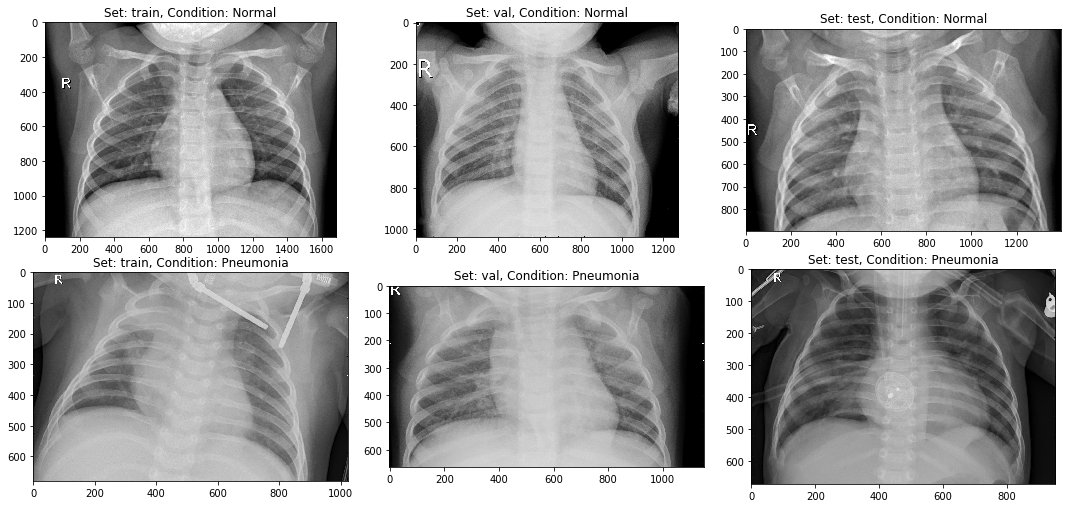

In [8]:
input_path = '/tmp/chest_xray1/'
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [9]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('{} Set:->, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

train Set:->, normal images: 1341, pneumonia images: 3875
val Set:->, normal images: 8, pneumonia images: 8
test Set:->, normal images: 234, pneumonia images: 390


In [0]:
#Preprocessing

In [0]:
#input_path = '../input/chest-xray-pneumonia//chest_xray/chest_xray/'

def pre_process_data(img_dims, batch_size):
    # Data generation objects
    #Training data generator
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       zoom_range=0.3, 
                                       vertical_flip=True)
    #Testing data generator
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    ###########################################################################

    # This is fed to the network in the specified batch sizes and image dimens
    # Reading from directory (TRAIN)
    train_gen = train_datagen.flow_from_directory(directory=input_path+'train', 
                                                  target_size=(img_dims, img_dims), 
                                                  batch_size=batch_size, 
                                                  class_mode='binary', 
                                                  shuffle=True)
    # Reading from directory (TEST)
    test_gen = test_val_datagen.flow_from_directory(directory=input_path+'test', 
                                                    target_size=(img_dims, img_dims), 
                                                    batch_size=batch_size, 
                                                    class_mode='binary', 
                                                    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    ###########################################################################
    # Defining matrices
    test_data = []
    test_labels = []

    # Iterating over each of the folders : train, val, test
    # Each contains two folders : NORMAL, PNEUMONIA

    for i in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + i)):
            # Reading each image
            img = plt.imread(input_path+'test'+i+img)
            # Resizing each image
            img = cv2.resize(img, (img_dims, img_dims))
            # Stack arrays in sequence depth wise (along third axis)
            img = np.dstack([img, img, img])
            # Normalizing
            img = img.astype('float32') / 255

            # Labelling
            # NORMAL = 0
            # pNEUMONIA = 1

            if i == '/NORMAL/':
              label = 0
                
            elif i == '/PNEUMONIA/':
                label = 1

            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [0]:
#Hyperparameters

In [11]:
img_dims = 150
epochs = 20
batch_size = 32
# Getting the data
train_gen, test_gen, test_data, test_labels = pre_process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
# Defining model

In [12]:

# Input layer
inputs = Input(shape = (img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)

model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 75, 75, 32)        1344     

In [0]:
'''model = tf.keras.models.Sequential([
                                    # 1st Conv
                                    tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same', input_shape = (img_dims, img_dims, 3)),
                                    tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    # 2nd Conv
                                    tf.keras.layers.SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'),
                                    tf.keras.layers.SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    # 3rd Conv
                                    tf.keras.layers.SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'),
                                    tf.keras.layers.SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
                                    # 4th Conv
                                    tf.keras.layers.SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'),
                                    tf.keras.layers.SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
                                    tf.keras.layers.Dropout(rate = 0.2),
                                    # 5th Conv
                                    tf.keras.layers.SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'),
                                    tf.keras.layers.SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
                                    tf.keras.layers.Dropout(rate = 0.2),
                                    # FC
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation = 'relu'),
                                    tf.keras.layers.Dropout(rate = 0.7),
                                    tf.keras.layers.Dense(128, activation = 'relu'),
                                    tf.keras.layers.Dropout(rate = 0.5),
                                    tf.keras.layers.Dense(64, activation = 'relu'),
                                    tf.keras.layers.Dropout(rate = 0.3),
                                    # Output neuron
                                    tf.keras.layers.Dense(1, activation = 'sigmoid')

])'''

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128 

In [14]:
#ad = tf.keras.optimizers.Adam(learning_rate=0.0001) 
                              #beta_1=0.9, 
                              #beta_2=0.999, 
                              #amsgrad=False

#Compiling model                             
model.compile(optimizer = 'adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#Callbacks
checkpoint = ModelCheckpoint(filepath = 'drive/My Drive/X-Ray/best_weights.hdf5', 
                             save_best_only = True, 
                             save_weights_only = True)



In [0]:
# Learning rate reduction
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.3, 
                              patience = 2, 
                              verbose = 2, 
                              mode = 'max')
# Early Stop
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.1, 
                           patience = 1, 
                           mode = 'min')

In [0]:
# Fitting the model

In [17]:
#session = tf.keras.backend.get_session()
#init = tf.global_variables_initializer()
#session.run(init)

history = model.fit_generator(train_gen, steps_per_epoch = train_gen.samples // batch_size,
                              epochs = epochs,
                              validation_data = test_gen,
                              validation_steps = test_gen.samples // batch_size,
                              callbacks=[checkpoint, lr_reduce]
                              )



Epoch 1/20
163/163 [==============================] - 81s 499ms/step - loss: 0.3598 - acc: 0.8374 - val_loss: 1.4348 - val_acc: 0.3783
Epoch 2/20
163/163 [==============================] - 76s 468ms/step - loss: 0.2847 - acc: 0.8775 - val_loss: 1.7164 - val_acc: 0.3682
Epoch 3/20
163/163 [==============================] - 74s 454ms/step - loss: 0.2775 - acc: 0.8846 - val_loss: 1.3071 - val_acc: 0.3801
Epoch 4/20
163/163 [==============================] - 74s 457ms/step - loss: 0.2560 - acc: 0.8995 - val_loss: 2.8507 - val_acc: 0.3750
Epoch 5/20
163/163 [==============================] - 74s 455ms/step - loss: 0.2431 - acc: 0.9030 - val_loss: 1.9070 - val_acc: 0.3868
Epoch 6/20
163/163 [==============================] - 74s 456ms/step - loss: 0.2224 - acc: 0.9122 - val_loss: 0.5415 - val_acc: 0.6740

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/20
163/163 [==============================] - 74s 456ms/step - loss: 0.1946 - acc: 0.9245 - val_los

In [0]:
#6:23 AM - 7:12 AM

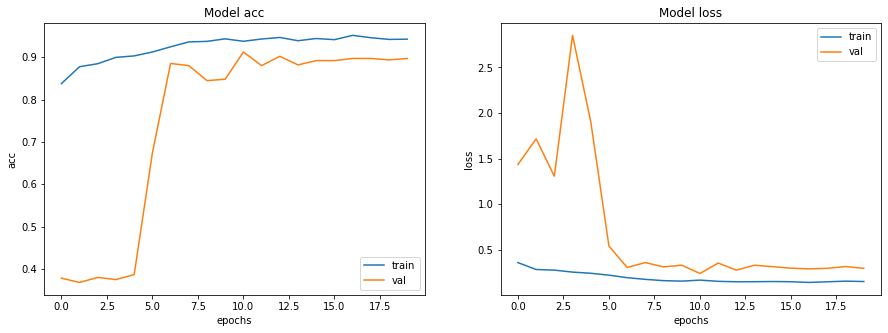

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

CONFUSION MATRIX
..........................
[[194  40]
 [ 19 371]]

TEST METRICS
..........................
Accuracy: 90.54 %
Precision: 90.27 %
Recall: 95.13 %
F1-score: 92.63

TRAIN METRIC
.........................
Train acc: 94.25


<Figure size 432x288 with 0 Axes>

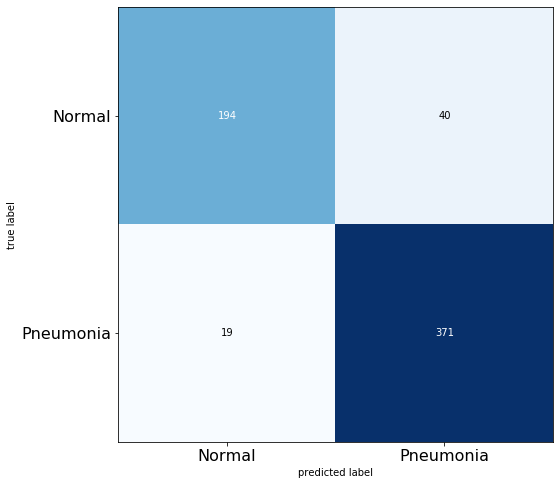

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100

cm = confusion_matrix(test_labels, np.round(preds))
plt.figure()

plot_confusion_matrix(cm,figsize=(12,8), 
                      hide_ticks=True, 
                      cmap=plt.cm.Blues)

plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)

tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX')
print('..........................')
print(cm)

print('\nTEST METRICS')
print('..........................')
########################################
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
########################################
print('Accuracy: {:.2f} %'.format(acc))
print('Precision: {:.2f} %'.format(precision))
print('Recall: {:.2f} %'.format(recall))
print('F1-score: {:.2f}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC')
print('.........................')
print('Train acc: {}'.format(np.round((history.history['acc'][-1])*100, 2)))

In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/ 